In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import nltk
import time
import random
import re
from PIL import Image
from operator import itemgetter

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall, Precision

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_curve, roc_auc_score,
                             f1_score, recall_score, precision_score)

# Additional imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from mlxtend.plotting import plot_confusion_matrix
from unidecode import unidecode


# Importing custom utilities
from spam_classification_utils import *

In [3]:
import sys
print(sys.prefix)

c:\Users\USER\OneDrive\Desktop\anti-spam_learning\.venv


In [4]:
# Setting display options
pd.set_option('display.max_colwidth', None)

In [5]:
# load dataset. It is always good practice to make a copy of the dataframe before you make any changes so you always have the original. 
df = pd.read_csv('Datasets/spam_data.csv', encoding='utf-8')
df_orig = df.copy()

In [6]:
# Apply the clean message function from spam_classification_utils
df['Message'] = df['Message'].apply(clean_message)

In [7]:
# split messages to find the number of unique words
unique_words = df['Message'].str.split(expand=True).stack().value_counts()
unique_words = unique_words.reset_index()
unique_words.columns = ['word', 'count']

In [8]:
# We import the list of stop words from and filter them out
stop_words = pd.read_json('stopwords-en.json')
stop_words = stop_words[0].tolist()
filtered_unique_words = unique_words[~unique_words['word'].isin(stop_words)]
display(filtered_unique_words[0:10])

,word,count
29,ur,390
47,ltgt,276
62,day,212
63,time,208
64,love,200
67,send,191
74,ü,169
77,txt,163
79,lor,160
88,reply,144


In [9]:
# Create a list of unique words
unique_words_list = filtered_unique_words['word'].tolist()

In [10]:
# Encode the labels
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])
display(df)

,Category,Message
0,0,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives around here though
...,...,...
5567,1,this is the nd time we have tried contact u u have won the pound prize claim is easy call now only p per minute btnationalrate
5568,0,will ü b going to esplanade fr home
5569,0,pity was in mood for that soany other suggestions
5570,0,the guy did some bitching but i acted like id be interested in buying something else next week and he gave it to us for free


In [11]:
# Useful way to select the X and y variables
X = df.Message
y = df.Category

In [12]:
# Again good practice to set the variables and directly use the variable names
SEQUENCE_LENGTH = 100 # the length of all sequences (number of words per sample)
EMBEDDING_SIZE = 100  # Using 100-Dimensional GloVe embedding vectors
TEST_SIZE = 0.25 # ratio of testing set

BATCH_SIZE = 64
EPOCHS = 20 # number of epochs

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# We save the dictionary in case we want to use it later
word_index = tokenizer.word_index

In [14]:
# Pad sequences to a fixed length. We make sure the padded sequences are of the same length by appending zeros before the message, and truncating the rest.
X = pad_sequences(sequences=X, 
                  maxlen=SEQUENCE_LENGTH, 
                  padding='pre', 
                  truncating='post')
display(X)

array([[   0,    0,    0, ...,   56, 3984,  136],
       [   0,    0,    0, ...,  442,    6, 1767],
       [   0,    0,    0, ..., 2716,  368, 2717],
       ...,
       [   0,    0,    0, ..., 8633,  232, 8634],
       [   0,    0,    0, ...,  199,   12,   47],
       [   0,    0,    0, ...,    2,   40,  243]], dtype=int32)

In [15]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Define the metrics
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve

In [17]:
# Define the embedding matrix using the 100 dimensional GloVe vectors (6B version)
def get_embedding_vectors(tokenizer, dim=100):
    embedding_index = {}
    with open(f"../glove.6B/glove.6B.{dim}d.txt", encoding='utf8') as f:
        for line in tqdm.tqdm(f, "Reading GloVe"):
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [18]:
# create the embedding matrix
embedding_matrix = get_embedding_vectors(tokenizer)

Reading GloVe: 0it [00:00, ?it/s]

Reading GloVe: 400000it [00:11, 36074.08it/s]


In [19]:

# Define RNN model sequentially

adv_RNN_model = Sequential()

# First, embed the words using loaded GloVe
adv_RNN_model.add(Embedding(len(tokenizer.word_index)+1,
        EMBEDDING_SIZE,
        weights=[embedding_matrix],
        trainable=True,
        mask_zero=True,
        ))

# Start adding LSTM layers. We will combine this with dropout and Batch Normalization to reduce overfitting
adv_RNN_model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # Set return_sequences=True
adv_RNN_model.add(layers.BatchNormalization())

adv_RNN_model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))  # Last LSTM can return sequences=False
adv_RNN_model.add(layers.BatchNormalization())

adv_RNN_model.add(layers.Dense(1, activation='sigmoid')) 

adv_RNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

In [ ]:
# # Define the log directory for TensorBoard
# file_name = 'test1'
# tensorboard = TensorBoard(log_dir="logs\\{}".format(file_name))

In [ ]:
# # Launches TensorBoard

# %load_ext tensorboard
# %tensorboard --logdir=./logs --host=localhost --port=6007

# # TensorBoard URL: 
# # http://localhost:6006


In [ ]:
# %reload_ext tensorboard

In [ ]:
display(X_train)

In [20]:
# Train the model using tensorboard as a callback
# history = adv_RNN_model.fit(X_train, y_train, verbose = 1, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks = [tensorboard])
history = adv_RNN_model.fit(X_train, y_train, verbose = 1, epochs=10, batch_size=32, validation_data=(X_val, y_val))
adv_RNN_model.summary()

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.7541 - auc: 0.8717 - fn: 39.1702 - fp: 401.0284 - loss: 0.5203 - prc: 0.6808 - precision: 0.3584 - recall: 0.8304 - tn: 1563.9646 - tp: 267.2837 - val_accuracy: 0.9623 - val_auc: 0.9845 - val_fn: 35.0000 - val_fp: 7.0000 - val_loss: 0.1819 - val_prc: 0.9381 - val_precision: 0.9421 - val_recall: 0.7651 - val_tn: 959.0000 - val_tp: 114.0000
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step - accuracy: 0.9620 - auc: 0.9602 - fn: 40.5106 - fp: 44.7021 - loss: 0.1562 - prc: 0.9049 - precision: 0.8400 - recall: 0.8739 - tn: 1934.1418 - tp: 252.0922 - val_accuracy: 0.9596 - val_auc: 0.9883 - val_fn: 42.0000 - val_fp: 3.0000 - val_loss: 0.1142 - val_prc: 0.9509 - val_precision: 0.9727 - val_recall: 0.7181 - val_tn: 963.0000 - val_tp: 107.0000
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - accuracy: 0.9689 - auc: 0.9778 - fn: 41.1986 - fp: 26.3830 - loss: 0.1135 - prc: 0.9288 - precision: 0.9074 - recall: 0.8549

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       863,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,092,501 (11.80 MB)

 Trainable params: 1,030,705 (3.93 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 2,061,412 (7.86 MB)

In [26]:
# Brief evaluation of the model
y_pred_prob = adv_RNN_model.predict(X_val)
y_pred = (y_pred_prob > 0.90).astype(int)  # Convert probabilities to binary predictions

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy of the model: {accuracy:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Accuracy of the model: 0.9857


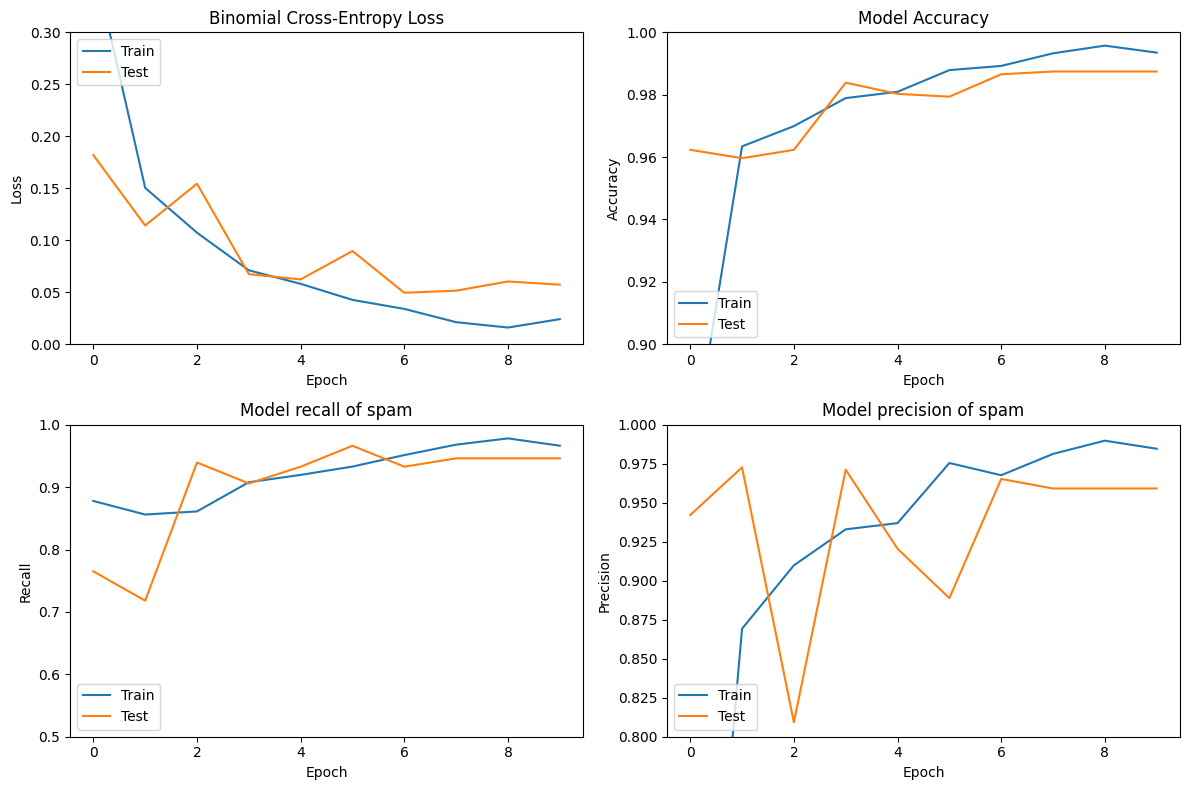

In [22]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
ax[0,0].plot(history.history['loss'], label='Train')
ax[0,0].plot(history.history['val_loss'], label='Test')
ax[0,0].set_title('Binomial Cross-Entropy Loss')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_ylim(0,0.3)
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(loc='upper left')
ax[0,1].plot(history.history['accuracy'], label='Train')
ax[0,1].plot(history.history['val_accuracy'], label='Test')
ax[0,1].set_title('Model Accuracy')
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_ylim(0.9,1)
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(loc='lower left')
ax[1,0].plot(history.history['recall'], label='Train')
ax[1,0].plot(history.history['val_recall'], label='Test')
ax[1,0].set_title('Model recall of spam')
ax[1,0].set_ylabel('Recall')
ax[1,0].set_ylim(0.5,1)
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(loc='lower left')
ax[1,1].plot(history.history['precision'], label='Train')
ax[1,1].plot(history.history['val_precision'], label='Test')
ax[1,1].set_title('Model precision of spam')
ax[1,1].set_ylabel('Precision')
ax[1,1].set_ylim(0.8,1)
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(loc='lower left')
plt.tight_layout()
plt.savefig('images/progression.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

Let's now search for the optimal classification threshold. We don't exactly need to be completely precise, so we'll test in intervals of 5%

In [34]:
test_thresholds = list(range(50, 101, 2))
print(test_thresholds)

[50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


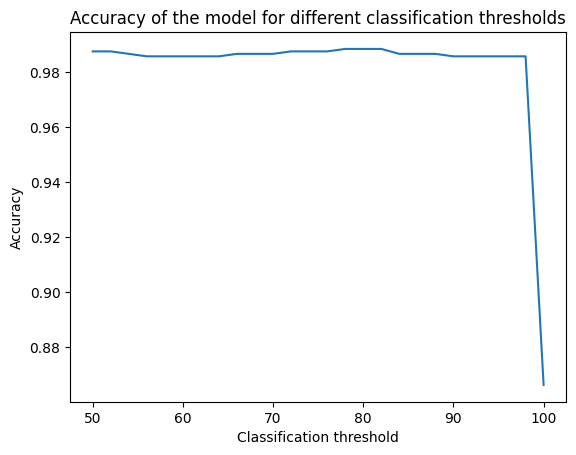

In [35]:
accuracy_list = []

for i in test_thresholds:
    y_pred_prob = adv_RNN_model.predict(X_val)
    y_pred = (y_pred_prob > i/100).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_list.append(accuracy)

plt.plot(test_thresholds, accuracy_list)
plt.title('Accuracy of the model for different classification thresholds')
plt.xlabel('Classification threshold')
plt.ylabel('Accuracy')
plt.savefig('images/accuracies.png',bbox_inches='tight',dpi=400, pad_inches=0.1)

plt.show()



In [36]:
print('the maximum accuracy is ' + str(max(accuracy_list)) + ' at ' + str(test_thresholds[accuracy_list.index(max(accuracy_list))]) + ' percent')

the maximum accuracy is 0.9883408071748879 at 78 percent


'the maximum accuracy is 0.9883408071748879 at 78 percent'

It seems setting the classification threshold at 78 percent results in the best performance

In [32]:
print(accuracy_list)

[0.8663677130044843, 0.8663677130044843, 0.8663677130044843, 0.8663677130044843, 0.8663677130044843, 0.8663677130044843, 0.8663677130044843, 0.8663677130044843, 0.8663677130044843, 0.8663677130044843, 0.8663677130044843]


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


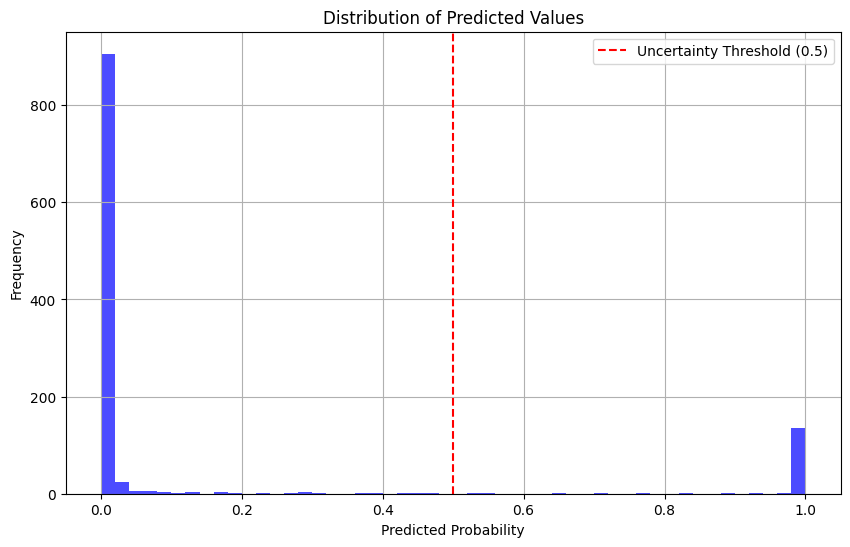

In [43]:
y_pred = adv_RNN_model.predict(X_val)


plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=50, color='blue', alpha=0.7)
plt.axvline(x=0.5, color='red', linestyle='--', label='Uncertainty Threshold (0.5)')
plt.title('Distribution of Predicted Values')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.savefig('images/Distribution.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


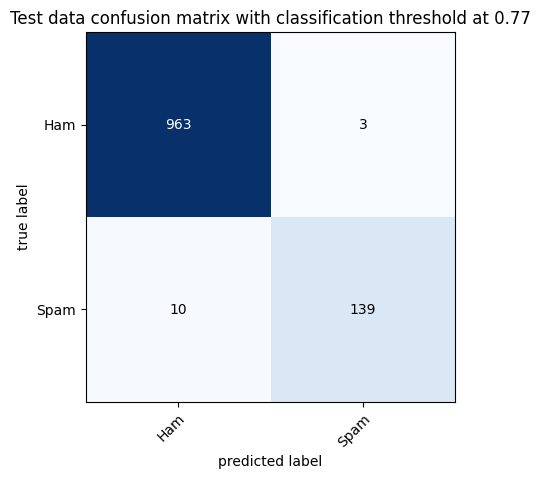

In [37]:
# Confusion matrix
y_pred = (adv_RNN_model.predict(X_val) > 0.78).astype("int32")

plot_confusion_matrix(confusion_matrix(y_val, y_pred), class_names=['Ham','Spam'])
plt.title('Test data confusion matrix with classification threshold at 0.77')
plt.savefig('images/confusion77.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()